## 파이토치를 이용한 이미지 분류 모델 학습용 코드
작동은 하지만 조정 필요.

# Install essential python packages

In [ ]:
!pip install -q timm albumentations wandb
!pip install catalyst
!python -m pip install --upgrade pip

import pkg_resources

# 현재 환경에 설치된 모든 패키지 정보를 가져옴
installed_packages = pkg_resources.working_set

# 패키지 이름과 버전을 출력
for package in installed_packages:
    print(package.key, package.version)

# Import essential python packages

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold
import torch
from torch import nn
import torch.nn.functional as F
import os
import time
from datetime import datetime
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from catalyst.data.sampler import BalanceClassSampler
import wandb
import timm
import shutil
import warnings

warnings.filterwarnings(action='ignore')

c:\Users\82103\AppData\Local\Programs\Python\Python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
args = {
    'model_name': 'mobilenetv3_small_100',  # 신경망 구조
    'lr': 1e-3,  # 학습률
    'weight_decay': 1e-4,  # 가중치 감쇠
    'drop_rate': 0.2,  # 학습 시 dropout 비율
    'image_size': 300,  # 이미지 크기
    'num_epochs': 2,  # 학습 반복수
    'batch_size': 1,  # 미니배치 크기
    'num_classes': 3,  # 판별할 클래스 개수
    'num_folds': 5,  # 데이터셋 분할 fold 개수
    'val_fold': 0,  # 검증용 fold 선택
    'seed': 42,  # 랜덤 seed 설정
    'log_step': 100,  # log 남길 iteration 반복 수
    'model_save_step': 2,  # model 저장할 epoch 반복 수
    'workspace_path': 'crop',  # 작업 위치
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': '[name_model]_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}
TRAIN_DATA_ROOT_PATH = os.path.join(args['workspace_path'], 'train')
TEST_DATA_ROOT_PATH = os.path.join(args['workspace_path'], 'test')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(43)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
#wandb 본인 것과 연동할 것
now = datetime.now().strftime('%Y-%m-%d-%H-%M')

wandb.init(project="2023", entity="a10e4")
wandb.run.name = f'road_classification_{now}'
#fd876340a8c014e0bcd7409fe0129e46e874bff8

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: a10e4. Use `wandb login --relogin` to force relogin


# GroupKFold splitting

In [7]:
dataset = []

for label, kind in enumerate(['dry', 'water', 'frozen']):
    #label = [0, 1, 2], kind = ['dry', 'water', 'frozen']

    #현재 디렉토리의 파일 목록 추출
    # 현 디렉토리 하의 전체 리소스 디렉토리/레이블된 리소스...n 디렉토리/ xxx.png 형식의 파일명 순회
    for path in glob(f'{TRAIN_DATA_ROOT_PATH}/{kind}/*.png', recursive=True):
        #from glob import glob
        # glob('*.exe')               # 현재 디렉터리의 .exe 파일
        #['python.exe', 'pythonw.exe']
        dataset.append({
            'kind': kind,
            'image_name': path.replace('\\', '/').split('/')[-1],
            'label': label
        })

random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=args['num_folds'])

#데이터프레임에 '폴드' 열 추가 후 0으로 값을 초기화
dataset.loc[:, 'fold'] = 0

#나눠진 폴드마다 학습/검증 다시 분할
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name'])):
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

# Dataset

In [8]:
class DatasetRetriever(Dataset):
    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds #무리/군집(마름, 습윤, 빙결)
        self.image_names = image_names #이미지 파일 이름
        self.labels = labels #무리/군집에 따른 레이블(마름=0, 습윤=1, 빙결=2)
        self.transforms = transforms #데이터 증대

    def __getitem__(self, index: int):
        kind, image_name, label = self.kinds[index], self.image_names[index], self.labels[index]
        image_path = f'{TRAIN_DATA_ROOT_PATH}/{kind}/{image_name}'.replace('\\', '/')
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            sample = {'image': image}

            # https://dojang.io/mod/page/view.php?id=2347
            # 함수/또는 클래스의 인자명과 인자 수가 다르면 에러가 나도록 정의되어 있음에 유의
            sample = self.transforms(**sample)

            image = sample['image']
            
        return image, label

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

# Simple Augmentations: Flips

In [9]:
# import albumentations as A
def get_train_transforms():
    return A.Compose([
            A.HorizontalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.5), #밝기 대비 무작위 조정, 50%확률
            #A.Normalize(mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])),
            A.Normalize(),
            ToTensorV2(p=1.0),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            #A.Normalize(mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])),
            A.Normalize(),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [10]:
train_dataset = DatasetRetriever(
    kinds = dataset[dataset['fold'] != args['val_fold']].kind.values,
    image_names = dataset[dataset['fold'] != args['val_fold']].image_name.values,
    labels = dataset[dataset['fold'] != args['val_fold']].label.values,
    transforms = get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] == args['val_fold']].kind.values,
    image_names=dataset[dataset['fold'] == args['val_fold']].image_name.values,
    labels=dataset[dataset['fold'] == args['val_fold']].label.values,
    transforms=get_valid_transforms(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


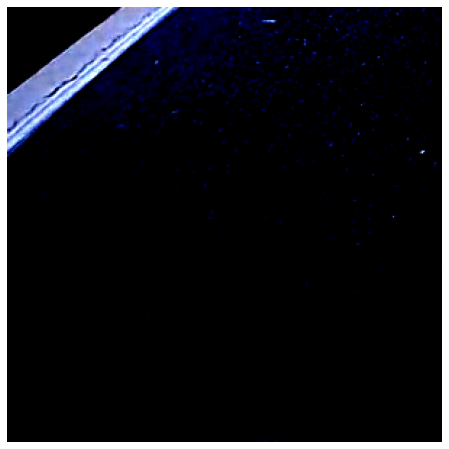

In [11]:
image, target = train_dataset[0]
numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
ax.imshow(numpy_image)

In [12]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler = BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size = args['batch_size'],
        pin_memory = False,
        drop_last = True,
    )
val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size = args['batch_size'],
        shuffle = False,
        sampler = SequentialSampler(validation_dataset),
        pin_memory = False,
    )

# Metrics

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, label, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = label.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # prediction: select k maximum at each output
    pred = pred.t()
    correct = pred.eq(label.view(1, -1).expand_as(pred))
    acc = correct.view(-1).float().sum(0, keepdim=True).mul_(100.0 / batch_size)  # acc = num of equivalcencs / target_size
    result = to_np(correct.view(-1))

    return acc, result

def to_np(x):
    return x.detach().cpu().data.numpy()

# Loss

In [14]:
loss_func = nn.CrossEntropyLoss().to(device)

# Model

In [15]:
!mkdir './checkpoints'
def get_net():
    net = timm.create_model(args['model_name'], num_classes=args['num_classes'], pretrained=True)
    return net

���� ������ �ùٸ��� �ʽ��ϴ�.


In [1]:
from torch import nn
from torch import Tensor

class A10E4_Net(nn.Module):
    def __init__(self) -> None:
      super(A10E4_Net, self).__init__()

      self.main = nn.Sequential(
          #group1 3채널 입력(컬러이미지), 특징 추출 유형1
          nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),
          
          #group2 특징 추출 유형1
          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group3, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2),

          #group4, 특징 추출 유형2
          nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout(p=0.2), #flatten_size = 96 * (image_height//16) * (image_width//16)

        )

      self.fully_connected = nn.Sequential(               #group5 분류
            nn.Linear(in_features=384, out_features=384),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=384, out_features=192),
            nn.Dropout(p=0.2),
            nn.Linear(192, 192),
            nn.Dropout(p=0.2),
            nn.LogSoftmax(dim=1),
        )


    def forward(self, image: Tensor) -> Tensor:
        """Returns logit for the given tensor."""
        #with torch.no_grad():
            #out = ImagePreProcessing()(image)
        out = self.main(image)
        out = out.view(out.size(0), -1)
        out = self.fully_connected(out)
        return out

print("init model done")

c:\Users\82103\AppData\Local\Programs\Python\Python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


init model done


# Save & Load pretrained model

In [17]:
def save_checkpoint(model, optimizer, best_acc, checkpoint_path, model_name, is_best, epoch):
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_acc': best_acc,
        'epoch': epoch
    }

    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    filename = os.path.join(checkpoint_path, f'{model_name}_model_epoch_{state["epoch"]}.pth')
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, f'{model_name}_model_best.pth'))
        
        art = wandb.Artifact(f'model3_2_{model_name}', type="model")
        art.add_file(f'./checkpoints/{model_name}_model_best.pth')
        wandb.log_artifact(art)


def load_checkpoint(model, optimizer, pretrained_path, device):
    state = torch.load(pretrained_path, map_location=device)
    model.load_state_dict(state['model'])
    best_acc = state['best_acc']
    epoch = state['epoch']
    print(f'\t## loaded trained models (epoch: {epoch}).... init epoch(1) \n')
    epoch = 1 #init
    return model, optimizer, best_acc, epoch

# Train & Validate

In [18]:
def train(train_loader, model, *args):
    # switch to train mode
    model.train()

    with torch.enable_grad():
        train_acc, train_loss = iteration('train', train_loader, model, *args)

    return train_acc, train_loss

In [19]:
def validate(val_loader, model, *args):
    # switch to eval mode
    model.eval()

    with torch.no_grad():
        val_acc, val_loss = iteration('val', val_loader, model, *args)

    return val_acc, val_loss

# Iteration

In [20]:
def iteration(mode, data_loader, model, optimizer, loss_func, epoch):
    am_batch_time = AverageMeter()
    am_data_time = AverageMeter()
    am_loss = AverageMeter()
    am_acc = AverageMeter()

    end = time.time()
    num_batch = np.ceil(len(data_loader)).astype(np.int32)

    for i, (input_img, target) in enumerate(data_loader):
        # measure data loading time
        am_data_time.update(time.time() - end)
        input_img = input_img.to(device)
        target = target.to(device)
        
        # feed-forward
        output = model(input_img)   # two output
        
        # calculate loss
        output = torch.nan_to_num(output)
        loss = loss_func(output, target)
        am_loss.update(loss.item(), input_img.size(0))

        # calculate accuracy
        class_prob = F.softmax(output, dim=1)
        class_acc, _ = accuracy(class_prob, target)
        am_acc.update(class_acc.item(), input_img.size(0))

        # compute gradient and do SGD step
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # measure elapsed time
        am_batch_time.update(time.time() - end)
        end = time.time()
        if (i + 1) % args['log_step'] == 0:
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})'
                  .format(epoch + 1, args['num_epochs'], i + 1, num_batch, batch_time=am_batch_time,
                          data_time=am_data_time, loss=am_loss, acc=am_acc))

    return am_acc.avg, am_loss.avg

# Pipeline: train, validate, log, and save

In [21]:
#2. Use that dataset to train a model
run = wandb.init(project="2023", job_type="model-training")

In [ ]:
args = {
    'model_name': 'A10E4_Net',  # 신경망 구조
    'lr': 1e-3,  # 학습률
    'weight_decay': 1e-4,  # 가중치 감쇠
    'drop_rate': 0.2,  # 학습 시 dropout 비율
    'image_size': 300,  # 이미지 크기
    'num_epochs': 1000,  # 학습 반복수
    'batch_size': 8,  # 미니배치 크기
    'num_classes': 3,  # 판별할 클래스 개수
    'num_folds': 5,  # 데이터셋 분할 fold 개수
    'val_fold': 0,  # 검증용 fold 선택
    'seed': 42,  # 랜덤 seed 설정
    'log_step': 100,  # log 남길 iteration 반복 수
    'model_save_step': 20,  # model 저장할 epoch 반복 수
    'workspace_path': 'crop',  # 작업 위치
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': 'A10E4_Net_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}

#model = get_net().to(device)
model = A10E4_Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay=args['weight_decay'])


if args['pretrained_name']:
    pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
    #model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)
else:
    initial_epoch = 0
    best_acc = 0

initial_epoch = 0
best_acc = 0

min_loss = 1000
for epoch in range(initial_epoch, args['num_epochs']):
    # train for one epoch
    print('# Training')
    train_acc, train_loss = train(train_loader, model, optimizer, loss_func, epoch)
    wandb.log({'train_acc': train_acc, 'train_loss': train_loss})
    print(f'epoch: {epoch}, train_acc: {train_acc}, train_loss: {train_loss}')

    # evaluate on validation set
    print('# Validation')
    val_acc, val_loss = validate(val_loader, model, optimizer, loss_func, epoch)
    wandb.log({'val_acc': val_acc, 'val_loss':val_loss})
    print(f'epoch: {epoch}, val_acc: {val_acc}, val_loss: {val_loss}')

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    min_loss = min(val_loss, min_loss)

    if is_best or (epoch + 1) % args['model_save_step'] == 0:
        save_checkpoint(model, optimizer, best_acc, args['checkpoint_dir'], args['model_name'], is_best, epoch + 1)

In [ ]:
args = {
    'model_name': 'efficientnet_b',  # 신경망 구조
    'lr': 1e-3,  # 학습률
    'weight_decay': 1e-4,  # 가중치 감쇠
    'drop_rate': 0.2,  # 학습 시 dropout 비율
    'image_size': 300,  # 이미지 크기
    'num_epochs': 3,  # 학습 반복수
    'batch_size': 8,  # 미니배치 크기
    'num_classes': 3,  # 판별할 클래스 개수
    'num_folds': 5,  # 데이터셋 분할 fold 개수
    'val_fold': 0,  # 검증용 fold 선택
    'seed': 42,  # 랜덤 seed 설정
    'log_step': 100,  # log 남길 iteration 반복 수
    'model_save_step': 1,  # model 저장할 epoch 반복 수
    'workspace_path': 'crop',  # 작업 위치
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': 'efficientnet_b0_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}


model_e = get_net().to(device)
optimizer = torch.optim.AdamW(model_e.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay=args['weight_decay'])

print()

if args['pretrained_name']:
    pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
    #model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)
else:
    initial_epoch = 0
    best_acc = 0

initial_epoch = 0
best_acc = 0

min_loss = 1000
for epoch in range(initial_epoch, args['num_epochs']):
    # train for one epoch
    print('# Training')
    train_acc, train_loss = train(train_loader, model_e, optimizer, loss_func, epoch)
    wandb.log({'train_acc': train_acc, 'train_loss': train_loss})
    print(f'epoch: {epoch}, train_acc: {train_acc}, train_loss: {train_loss}')

    # evaluate on validation set
    print('# Validation')
    val_acc, val_loss = validate(val_loader, model_e, optimizer, loss_func, epoch)
    wandb.log({'val_acc': val_acc, 'val_loss':val_loss})
    print(f'epoch: {epoch}, val_acc: {val_acc}, val_loss: {val_loss}')

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    min_loss = min(val_loss, min_loss)

    if is_best or (epoch + 1) % args['model_save_step'] == 0:
        save_checkpoint(model_e, optimizer, best_acc, args['checkpoint_dir'], args['model_name'], is_best, epoch + 1)

In [ ]:
#모델 저장
art = wandb.Artifact("road_test", type="model")

art.add_file("checkpoints/mobilenetv3_small_100_model_best.pth")
wandb.log_artifact(art)

# 검증

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
args = {
    'model_name': 'mobilenetv3_small_100',  # 신경망 구조
    'workspace_path': 'prop/crop',  # 작업 위치
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'lr': 1e-3,
    'num_epochs': 1,  # 학습 반복수
    'weight_decay': 1e-4,  # 가중치 감쇠
    'log_step': 250, 
    'num_classes': 3,  # 판별할 클래스 개수
    'pretrained_name': 'mobilenetv3_small_100_model_epoch_1000.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}

model = get_net().to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay=args['weight_decay'])
pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)

# evaluate on validation set
print('# Validation')
val_acc, val_loss = validate(val_loader, model, optimizer, loss_func, 0)
print(f'val_acc: {val_acc}, val_loss: {val_loss}')

	## loaded trained models (epoch: 1000).... init epoch(1) 

# Validation
val_acc: 53.44827586206897, val_loss: 8.399543081795423


In [5]:
import numpy as np
import cv2
from torchvision import transforms
import torch
import timm
import os
import torch.nn.functional as F

args = {
    'model_name': 'A10E4_Net',  # 신경망 구조
    'lr': 1e-3,  # 학습률
    'weight_decay': 1e-4,  # 가중치 감쇠
    'image_size': 300,  # 이미지 크기
    'num_classes': 3,  # 판별할 클래스 개수
    'seed': 42,  # 랜덤 seed 설정
   
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': 'A10E4_Net_model_epoch_3.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}

def get_net():
    net = timm.create_model(args['model_name'], num_classes=args['num_classes'], pretrained=True)
    return net


def load_checkpoint(model, optimizer, pretrained_path, device):
    state = torch.load(pretrained_path, map_location=device)
    model.load_state_dict(state['model'])
    best_acc = state['best_acc']
    epoch = state['epoch']
    print(f'\t## loaded trained models (epoch: {epoch}).... init epoch(1) \n')
    epoch = 1 #init
    return model, optimizer, best_acc, epoch



# 입력 데이터 생성
image = cv2.imread('D:/AP/road/crop/test/dry/0051.png', cv2.IMREAD_COLOR)
print(image.shape)
# 이미지를 RGB 색상 순서로 변환
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cv2.imwrite('D:/AP/road/t.png', image)


# 이미지 변환
transform = transforms.Compose([
    #transforms.Resize((300, 300)),  # 모델에 맞는 크기로 리사이징
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize(           # 이미지 정규화
        mean=[0.485, 0.456, 0.406],  # ImageNet 데이터셋의 평균
        std=[0.229, 0.224, 0.225]    # ImageNet 데이터셋의 표준 편차
    )
])

input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)  # 배치 차원 추가

#print(type(input_tensor))
#print(input_tensor)
#print(input_tensor.shape)

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 모델 불러오기 및 디바이스 설정
model = A10E4_Net().to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay=args['weight_decay'])
pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)

input_img = input_tensor.to(device)

# 추론 실행
#model.eval()  # 모델을 추론 모드로 설정
with torch.no_grad():
    outputs = model(input_img)
#print(outputs)


probabilities = F.softmax(outputs, dim=1)
rounded_probabilities = torch.round(probabilities * 1000) / 1000  # 소수점 아래 3자리까지 반올림

# 가장 높은 확률과 해당 클래스 인덱스 찾기
max_probability, predicted_class = torch.max(probabilities, dim=1) # outputs.topk(k=1, dim=1, largest=True, sorted=True)


#print('모델 출력(처리x)', outputs)
#print('모델 출력(처리o)', rounded_probabilities) # tensor([[1., 0., 0.]]) 형태 출력. dry는 0, water는 1, frozen은 2
print(f'분류 : {predicted_class.item()}, 확률 : {max_probability.item()} ')

(300, 300, 3)
<class 'torch.Tensor'>
tensor([[[[-0.7479, -0.7650, -0.7650,  ...,  0.0398,  0.0398,  0.0741],
          [-0.7137, -0.7479, -0.7479,  ...,  0.0227,  0.0227,  0.0227],
          [-0.6965, -0.7137, -0.7137,  ...,  0.0227,  0.0227,  0.0056],
          ...,
          [-0.3027, -0.3883, -0.4568,  ..., -0.9020, -0.9020, -0.9192],
          [-0.5424, -0.5596, -0.5424,  ..., -0.9020, -0.9192, -0.9363],
          [-0.9363, -0.7650, -0.6965,  ..., -0.9192, -0.9363, -0.9534]],

         [[-0.7052, -0.7227, -0.7227,  ...,  0.0651,  0.0651,  0.0826],
          [-0.6877, -0.7052, -0.7052,  ...,  0.0476,  0.0476,  0.0476],
          [-0.6527, -0.6877, -0.6877,  ...,  0.0476,  0.0476,  0.0301],
          ...,
          [-0.1450, -0.2325, -0.3025,  ..., -0.7927, -0.7927, -0.8102],
          [-0.3901, -0.4076, -0.3901,  ..., -0.7927, -0.8102, -0.8277],
          [-0.7927, -0.6352, -0.5476,  ..., -0.8102, -0.8277, -0.8452]],

         [[-0.5321, -0.5670, -0.5670,  ...,  0.1651,  0.1651,  0.

In [ ]:
print(model)

In [ ]:
model.state_dict()

In [ ]:
import torch
import torch.onnx as onnx

model.eval()
# ONNX로 변환

# 입력 예시를 생성합니다.
#dummy_input = torch.randn(batch_size, input_dim, height, width) 배치 사이즈는 자유, 인풋 차원은 학습시킨 입력값으로.
dummy_input = torch.randn(1, 3, 300, 300)
onnx_filename = 'mobilenetv3_small_100_best.onnx'  # ONNX 파일의 이름을 지정합니다.
onnx.export(model, dummy_input, onnx_filename)

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
class_labels = {
    0: 'dry',
    1: 'water',
    2: 'frozen'
}

# 클래스 레이블 파일 생성
with open('class_labels.txt', 'w') as f:
    for index, label in class_labels.items():
        f.write(f'{index}: {label}\n')

In [ ]:
args = {
    'model_name': 'tf_efficientnet_b0_true',  # 신경망 구조
    'workspace_path': 'prop/crop',  # 작업 위치
    'checkpoint_dir': 'checkpoints',  # 모델 저장 디렉토리
    'log_step': 250, 
    'pretrained_name': 'A10E4Net_model_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}


pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
Mymodel, optimizer, best_acc, initial_epoch = load_checkpoint(Mymodel, optimizer, pretrained_path, device)

# evaluate on validation set
print('# Validation')
val_acc, val_loss = validate(val_loader, Mymodel, optimizer, loss_func, 0)
print(f'val_acc: {val_acc}, val_loss: {val_loss}')

	## loaded trained models (epoch: 40).... init epoch(1) 

# Validation
Epoch: [1/40][250/251]	Time 0.118 (0.121)	Data 0.090 (0.094)	Loss 0.0450 (0.1576) 	Accuracy 100.0000 (92.1500)


# 출력

In [ ]:
#args['pretrained_name'] = 'tf_efficientnet_b0_true_model_best.pth'
args['pretrained_name'] = 'tf_efficientnet_b0_false_model_best.pth'
#args['pretrained_name'] = 'Mymodel_model_best.pth'


print('use -> ',args['checkpoint_dir'], args['pretrained_name'])

pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
model2, _, _, _ = load_checkpoint(model, optimizer, pretrained_path, device)
model2.eval()

In [ ]:
class DatasetSubmissionRetriever(Dataset):
    def __init__(self, image_names, transforms=None):
        super().__init__()
        self.image_names = image_names
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_name = self.image_names[index]
        image_path = f'{TEST_DATA_ROOT_PATH}/{image_name}'
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image_name, image

    def __len__(self) -> int:
        return self.image_names.shape[0]



In [ ]:
dataset = DatasetSubmissionRetriever(
    image_names=np.array([path.replace('\\', '/').split('/')[-1] for path in glob(f'{TEST_DATA_ROOT_PATH}/*.png')]),
    transforms=get_valid_transforms(),
)


test_loader = DataLoader(
    dataset,
    batch_size=args['batch_size'],
    shuffle=False,
    drop_last=False,
)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
df_result = pd.DataFrame(columns=['id', 'label'])
for step, (image_names, images) in enumerate(test_loader):
    print(step, end='\r')
    images = images.to(device)
    output = model(images)
    class_prob = F.softmax(output, dim=1)
    _, class_pred = output.topk(1, 1, True, True)  # prediction: select k maximum at each output
    label = class_pred.view(-1).detach().cpu().numpy()
    df_curr = pd.DataFrame({
        'id': image_names,
        'label': label
    })
    df_result = pd.concat([df_result, df_curr], axis=0, ignore_index=True)

In [ ]:
current_time = datetime.now().strftime(r'%y-%m-%d_%H-%M-%S')
df_result.to_csv(f'submission_{current_time}.csv', index=False)
df_result.head()

,id,label
0,10971.png,1
1,11032.png,0
2,11053.png,0
3,10954.png,0
4,11034.png,1
